In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray
import tensorflow as tf
import enso

In [2]:
np.random.seed(0)

## Extracting SST, ONI and Anomaly

In [3]:
signals = ['pna', 'ea', 'wa', 'wp', 'eu', 'soi', 'esoi', 'nino12', 'nino34', 'nino4']
signal_length = 6000
n_signals = 11

datapath = '~/CM4_ctrl_indices.nc'

all_signals_nc = xarray.open_dataset(datapath, decode_times = False)
all_signals = np.zeros((signal_length, 1))

for signal in signals:
    new_signal = (all_signals_nc[signal].values).reshape((signal_length, 1))
    all_signals = np.append(all_signals, new_signal, axis = 1)
    
nino34 = all_signals_nc['nino34'].values
clm = enso.climatology(nino34)
anm = enso.anomaly(nino34, clm)
oni = enso.ONI(anm)
time = np.arange(anm.shape[0])

## Converting Time Series to Train/Validation/Test Datasets and Labels

We first decide how far into the future we aim to predict (T months into the future), how much history we use to do so (H months of past values information Hmax into the past), and number of extra features (means of previous months).

In [4]:
T = 12
H = 48

# One Signal

We then decide which time series to use for training (input_signal) and which time series to predict (output_signal):

In [5]:
input_signal = np.array(oni).copy()
input_signal = np.reshape(input_signal, (signal_length, 1))

output_signal = np.array(oni).copy()

We then normalize the input and output signals for more reliable performance:

In [6]:
input_signal = enso.normalize(input_signal)
output_signal = enso.normalize(output_signal)

Now we can create: (1) the feature matrix, i.e. the data to be used to predict the future time series value, and (2) the desired label vector.

In [7]:
data = enso.ts2history(input_signal, T, H)

labels = enso.ts2diff(output_signal, T, H)
to_add = enso.ts2remainder(output_signal, T, H)
reconstructed = labels + to_add
time2D = enso.time2time2D(time, T, H)

(test_start, test_end) = (6, 7)
(val_start, val_end) = (4, 5)

(train, test) = enso.split(data, test_start, test_end)
(train_labels, test_labels) = enso.split(labels, test_start, test_end)
(train_to_add, test_to_add) = enso.split(to_add, test_start, test_end)
(train_reconstructed, test_reconstructed) = enso.split(reconstructed, test_start, test_end)
(train_time2D, test_time2D) = enso.split(time2D, test_start, test_end)

batch_size = 6

(train, val) = enso.LSTM_prep_tuple(enso.split(train, val_start, val_end), batch_size)
(train_labels, val_labels) = enso.LSTM_prep_tuple(enso.split(train_labels, val_start, val_end), batch_size)
(train_to_add, val_to_add) = enso.LSTM_prep_tuple(enso.split(train_to_add, val_start, val_end), batch_size)
(train_reconstructed, val_reconstructed) = enso.LSTM_prep_tuple(enso.split(train_reconstructed, val_start, val_end), batch_size)
(train_time2D, val_time2D) = enso.LSTM_prep_tuple(enso.split(train_time2D, val_start, val_end), batch_size)

## Learning Optimal Weights for all t simulatously:

In [8]:
epochs = 20
neurons = 12

In [9]:
cumulative_model = tf.keras.models.Sequential([
                      tf.keras.layers.LSTM(neurons, batch_input_shape=(batch_size, data.shape[1], data.shape[2]), return_sequences = False, stateful=True),
                      tf.keras.layers.Dense(T,  kernel_initializer = 'normal', activation = 'linear')
                    ])

cumulative_model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])
cumulative_model.fit(train, train_labels, epochs = epochs, batch_size = batch_size, verbose = 0)

cumulative_val_pred = cumulative_model.predict(val)
cumulative_val_pred_reconstructed = cumulative_val_pred + val_to_add

mult_val_pred_rmse_1signal = enso.rmse(val_reconstructed, cumulative_val_pred_reconstructed)                
mult_val_pred_corr_1signal = enso.correlation(val_reconstructed, cumulative_val_pred_reconstructed)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.


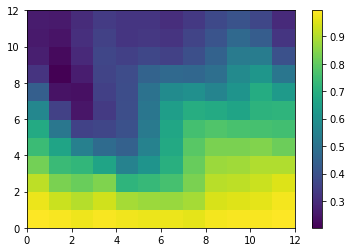

In [10]:
enso.plot_monthly_correlation(cumulative_val_pred_reconstructed, val_reconstructed, T);

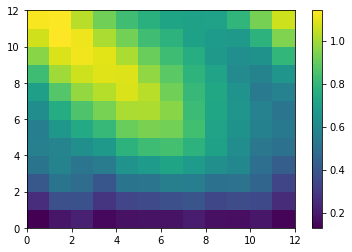

In [11]:
enso.plot_monthly_rmse(cumulative_val_pred_reconstructed, val_reconstructed, T);

## Learning Optimal Weights Separately:

In [12]:
val_pred_rmse_1signal = np.zeros(T)
val_pred_corr_1signal = np.zeros(T)
individual_val_pred = {}
individual_val_pred_reconstructed = {}

In [13]:
for t in range(T):
    
    individual_model = tf.keras.models.Sequential([
                  tf.keras.layers.LSTM(neurons, batch_input_shape=(batch_size, data.shape[1], data.shape[2]), stateful=True),
                  tf.keras.layers.Dense(1,  kernel_initializer='normal', activation = 'linear')
            ])
    
    individual_model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])
    individual_model.fit(train, train_labels[:, t], epochs = epochs, batch_size = batch_size, verbose = 0)
    
    individual_val_pred[t] = individual_model.predict(val).flatten() # save individual predictions for t
    individual_val_pred_reconstructed[t] = individual_val_pred[t] + val_to_add[:, t]
    
    val_pred_rmse_1signal[t] = enso.rmse(val_reconstructed[:, t], individual_val_pred_reconstructed[t])
    val_pred_corr_1signal[t] = enso.correlation(val_reconstructed[:, t], individual_val_pred_reconstructed[t])

# Multiple Signals

In [14]:
input_signals = np.array(all_signals).copy()
input_signals = enso.normalize(input_signals)

data = enso.ts2history(input_signals, T, H)

(test_start, test_end) = (6, 7)
(val_start, val_end) = (4, 5)

(train, test) = enso.split(data, test_start, test_end)
(train, val) = enso.LSTM_prep_tuple(enso.split(train, val_start, val_end), batch_size)

## Learning Optimal Weights for all t simulatously:

In [15]:
cumulative_model = tf.keras.models.Sequential([
                      tf.keras.layers.LSTM(neurons, batch_input_shape=(batch_size, data.shape[1], data.shape[2]), return_sequences = False, stateful=True),
                      tf.keras.layers.Dense(T,  kernel_initializer = 'normal', activation = 'linear')
                    ])

cumulative_model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])
cumulative_model.fit(train, train_labels, epochs = epochs, batch_size = batch_size, verbose = 0)

cumulative_val_pred = cumulative_model.predict(val)
cumulative_val_pred_reconstructed = cumulative_val_pred + val_to_add

mult_val_pred_rmse = enso.rmse(val_reconstructed, cumulative_val_pred_reconstructed)                
mult_val_pred_corr = enso.correlation(val_reconstructed, cumulative_val_pred_reconstructed)

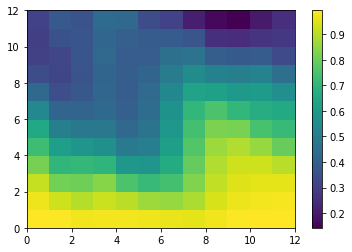

In [16]:
enso.plot_monthly_correlation(cumulative_val_pred_reconstructed, val_reconstructed, T);

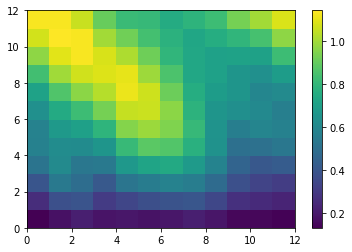

In [17]:
enso.plot_monthly_rmse(cumulative_val_pred_reconstructed, val_reconstructed, T);

## Learning Optimal Weights Separately:

In [18]:
val_pred_rmse = np.zeros(T)
val_pred_corr = np.zeros(T)

In [19]:
for t in range(T):
    
    individual_model = tf.keras.models.Sequential([
                  tf.keras.layers.LSTM(neurons, batch_input_shape=(batch_size, data.shape[1], data.shape[2]), stateful=True),
                  tf.keras.layers.Dense(1,  kernel_initializer='normal', activation = 'linear')
            ])
    
    individual_model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])
    individual_model.fit(train, train_labels[:, t], epochs = epochs, batch_size = batch_size, verbose = 0)
    
    individual_val_pred[t] = individual_model.predict(val).flatten() # save individual predictions for t
    individual_val_pred_reconstructed[t] = individual_val_pred[t] + val_to_add[:, t]
    
    val_pred_rmse[t] = enso.rmse(val_reconstructed[:, t], individual_val_pred_reconstructed[t])
    val_pred_corr[t] = enso.correlation(val_reconstructed[:, t], individual_val_pred_reconstructed[t])

# Results

In [20]:
(persistance_corr, persistance_rmse) = enso.persistance_corr_rmse(oni, T)

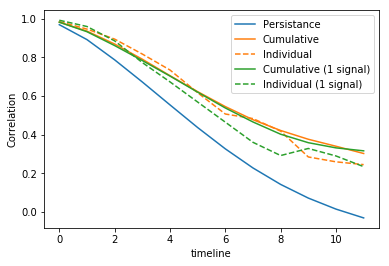

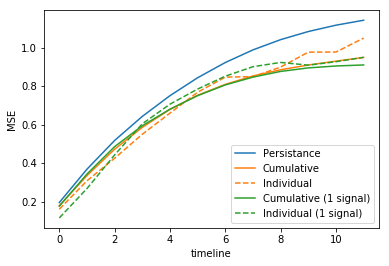

In [21]:
plt.plot(persistance_corr, label = "Persistance");
plt.plot(mult_val_pred_corr, label = "Cumulative");
plt.plot(val_pred_corr, 'C1--', label = "Individual");
plt.plot(mult_val_pred_corr_1signal, label = "Cumulative (1 signal)");
plt.plot(val_pred_corr_1signal, 'C2--', label = "Individual (1 signal)");
plt.ylabel('Correlation');
plt.xlabel('timeline');
plt.legend();
plt.figure();


plt.plot(persistance_rmse, label = "Persistance");
plt.plot(mult_val_pred_rmse, label = "Cumulative");
plt.plot(val_pred_rmse, 'C1--', label = "Individual");
plt.plot(mult_val_pred_rmse_1signal, label = "Cumulative (1 signal)");
plt.plot(val_pred_rmse_1signal, 'C2--', label = "Individual (1 signal)");
plt.ylabel('MSE');
plt.xlabel('timeline');
plt.legend();